# CME vs stETH prices

### Functions

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_scatter(dataset, tf):

    # Set the size of the plot
    plt.figure(figsize=(10, 6))  # Width and height in inches

    # Add regression line
    sns.regplot(x='Price_steth', y='Price_cme', data=dataset, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})

    # Plotting the dataset
    sns.scatterplot(x='Price_steth', y='Price_cme', data=dataset)
    plt.title(f'Scatter Plot of CME Price vs stEth Price on {tf} timeframe')
    plt.xlabel('Price CME')
    plt.ylabel('Price stEth')
    plt.show()


In [45]:
def remove_outliers(df):
    for col in ['Price_cme','Price_steth']:
        # Calculate the 99th percentile
        upper_limit = df[col].quantile(0.99)

        # Filter the dataset to remove extreme outliers
        filtered_df = df[df[col] <= upper_limit]
    return filtered_df

In [46]:
def show_pearson_coef(df):
    # Calculate the Pearson correlation coefficient
    correlation_coefficient = df['Price_cme'].corr(df['Price_steth'])
    print("Pearson Correlation Coefficient:", correlation_coefficient)

### Datasets

In [47]:
import pandas as pd

col_names = ['Entry Date UTC', 'Price']

# Load csv files for CME data
cme_data_1h = pd.read_csv('../data/cme/cme_1h.csv', usecols=col_names)
cme_data_5m = pd.read_csv('../data/cme/cme_5m.csv', usecols=col_names)
cme_data_1m = pd.read_csv('../data/cme/cme_1m.csv', usecols=col_names)

# Date conversion & remove outliers
for df in (cme_data_1h, cme_data_5m, cme_data_1m):
    df['Entry Date UTC'] = pd.to_datetime(df['Entry Date UTC'], format='%Y%m%dT%H:%M:%S')

# Load csv files for stEth data
steth_data_1h = pd.read_csv('../data/steth/steth_1h.csv', usecols=col_names)
steth_data_5m = pd.read_csv('../data/steth/steth_5m.csv', usecols=col_names)
steth_data_1m = pd.read_csv('../data/steth/steth_1m.csv', usecols=col_names)

# Date conversion & remove outliers
for df in (steth_data_1h, steth_data_5m, steth_data_1m):
    df['Entry Date UTC'] = pd.to_datetime(df['Entry Date UTC'])

# Merge datasets using date
dataset_1h = pd.merge(cme_data_1h, steth_data_1h, on='Entry Date UTC', suffixes=('_cme', '_steth'))
dataset_5m = pd.merge(cme_data_5m, steth_data_5m, on='Entry Date UTC', suffixes=('_cme', '_steth'))
dataset_1m = pd.merge(cme_data_1m, steth_data_1m, on='Entry Date UTC', suffixes=('_cme', '_steth'))

# Remove outliers
dataset_1h = remove_outliers(dataset_1h)
dataset_5m = remove_outliers(dataset_5m)
dataset_1m = remove_outliers(dataset_1m)

# dataset_1h = remove_outliers(dataset_1h)

print(dataset_1h.head())


       Entry Date UTC  Price_cme  Price_steth
2 2022-01-03 01:00:00     3812.0      3791.57
3 2022-01-03 02:00:00     3812.5      3796.46
4 2022-01-03 03:00:00     3807.5      3787.55
5 2022-01-03 04:00:00     3791.5      3776.99
6 2022-01-03 05:00:00     3802.5      3775.48


### Scatter Plots

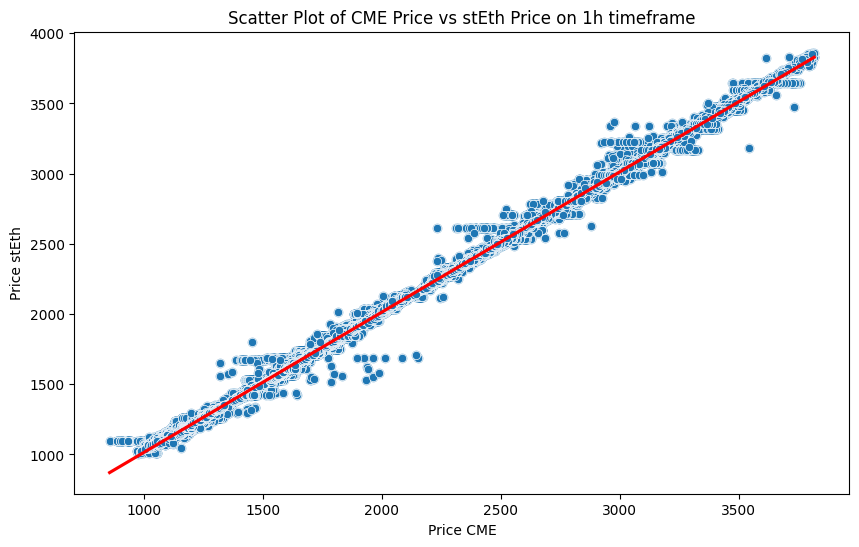

In [48]:
show_scatter(dataset_1h, '1h')

In [49]:
show_pearson_coef(dataset_1h)

Pearson Correlation Coefficient: 0.9987047453024661


In [50]:
dataset_1h.describe()

,Entry Date UTC,Price_cme,Price_steth
count,19332,19332.000000,19332.000000
mean,2023-02-28 03:27:53.743016960,2030.335092,2016.449898
min,2022-01-03 01:00:00,1003.000000,855.190000
25%,2022-08-01 12:45:00,1585.500000,1574.317500
50%,2023-02-27 17:30:00,1843.000000,1834.580000
75%,2023-09-25 19:15:00,2435.000000,2415.055000
max,2024-04-30 23:00:00,3861.500000,3817.690000
std,NaN,668.226868,668.316751


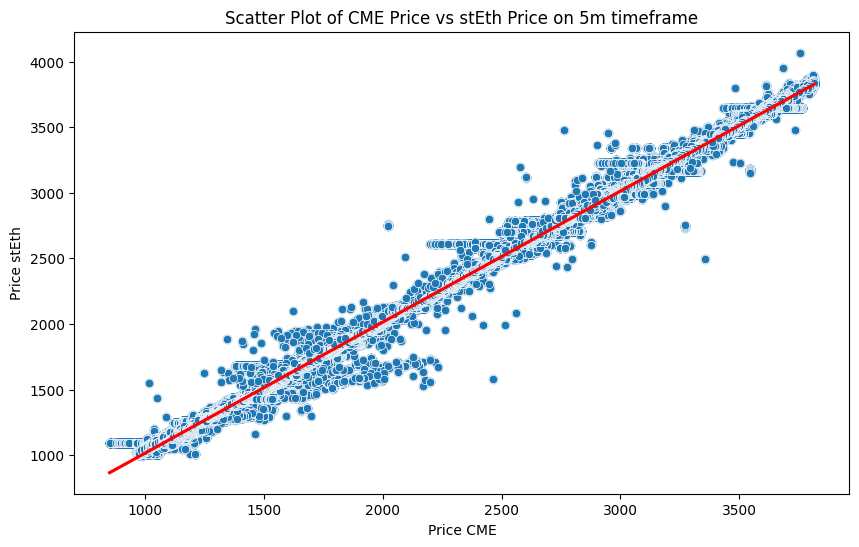

In [51]:
show_scatter(dataset_5m, '5m')

In [52]:
show_pearson_coef(dataset_5m)

Pearson Correlation Coefficient: 0.9986653771122587


In [53]:
dataset_5m.describe()

,Entry Date UTC,Price_cme,Price_steth
count,232003,232003.000000,232003.000000
mean,2023-02-28 03:40:03.439610624,2030.332657,2016.472322
min,2022-01-03 00:10:00,996.000000,850.540000
25%,2022-08-01 12:52:30,1585.500000,1574.480000
50%,2023-02-27 17:20:00,1843.000000,1834.890000
75%,2023-09-25 19:42:30,2435.500000,2415.815000
max,2024-04-30 23:55:00,4067.000000,3815.440000
std,NaN,668.259875,668.346318


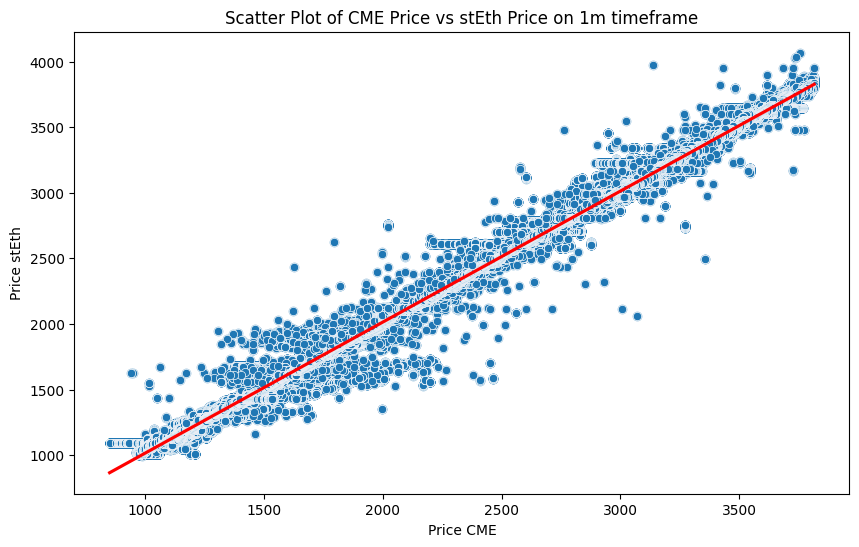

In [54]:
show_scatter(dataset_1m, '1m')

In [55]:
show_pearson_coef(dataset_1m)

Pearson Correlation Coefficient: 0.9986534934073878


### Outliers hunting

In [56]:
from sklearn.linear_model import LinearRegression

def show_outliers(df, n_times_sd):
    '''
    This function fits a linear regression model, calculates residuals, and prints rows where
    the absolute residuals exceed a specified number of standard deviations from the mean residual, 
    identifying these as outliers.
    '''
    # Fit the regression model
    model = LinearRegression()
    model.fit(df[['Price_cme']], df['Price_steth'])

    # Calculate predicted values
    df['predicted'] = model.predict(df[['Price_cme']])

    # Calculate residuals
    df['residuals'] = df['Price_steth'] - df['predicted']

    # Calculate the absolute residuals to determine the distance from the line
    df['abs_residuals'] = df['residuals'].abs()

    # Define a threshold
    std_dev = df['abs_residuals'].std()
    threshold = n_times_sd * std_dev

    # Filter rows where the absolute residuals are greater than the threshold
    outliers = df[df['abs_residuals'] > threshold]

    print(outliers[['Entry Date UTC', 'Price_cme', 'Price_steth', 'predicted', 'residuals']])


In [64]:
show_outliers(dataset_5m, 18)

            Entry Date UTC  Price_cme  Price_steth    predicted   residuals
8199   2022-02-01 15:15:00     2749.0      2022.93  2734.273354 -711.343354
8200   2022-02-01 15:20:00     2751.5      2022.93  2736.770340 -713.840340
8201   2022-02-01 15:25:00     2764.0      2022.93  2749.255272 -726.325272
8202   2022-02-01 15:30:00     2757.5      2022.93  2742.763108 -719.833108
8203   2022-02-01 15:35:00     2748.5      2022.93  2733.773957 -710.843957
22542  2022-03-25 13:30:00     3199.5      2578.20  3184.230303 -606.030303
33998  2022-05-06 02:10:00     2733.5      3272.60  2718.792038  553.807962
33999  2022-05-06 02:15:00     2738.0      3272.60  2723.286614  549.313386
34000  2022-05-06 02:20:00     2743.0      3272.60  2728.280587  544.319413
34001  2022-05-06 02:25:00     2753.5      3272.60  2738.767930  533.832070
67049  2022-09-02 19:25:00     1529.5      2168.24  1516.243389  651.996611
67880  2022-09-05 19:40:00     1573.0      2176.02  1559.690952  616.329048
69489  2022-